### 正規化をしてテキストファイルに起こすノートブックです

In [76]:
import glob
import math

def split_list(l,n):
    for idx in range(0,len(l)-1,n):
        yield l[idx:idx + n]

def normalize_points(path,xmin,xmax,ymin,ymax):
    #LiDARからの生のデータを入力してね
    files = glob.glob(path)
    if len(files) == 0:
        print('No data available')
        return 
    with open(files[0],'r') as f:
        data = f.read().split('\n')
    normalize_x = []
    normalize_y = []
    for idx in range(1,len(data)-1):
        d_k = data[idx].replace('(','').replace(')',',').replace('[','').replace(']','')
        sp_ka = d_k.split(',')
        angl = [] #角度
        dist = [] #距離
        result = list(split_list(sp_ka,3))
        for idx in range(len(result)):
            angl.append(float(result[idx][1]))
            dist.append(float(result[idx][2]))

        points_x = []
        points_y = []
        for i in range(len(angl)):
            x = dist[i] * math.cos(math.radians(angl[i])) 
            y = math.sqrt(dist[i] ** 2 - x ** 2) 
            x = x / 10
            y = y / 10
            if(0 <= float(angl[i]) and float(angl[i]) <= 90):
                points_x.append(x)
                points_y.append(-y)
            elif(90 < float(angl[i]) and float(angl[i]) <= 180):
                points_x.append(x)
                points_y.append(-y)
            elif(180 < float(angl[i]) and float(angl[i]) <= 270):
                points_x.append(x)
                points_y.append(y)
            else:
                points_x.append(x)
                points_y.append(y)
        #ここで座標指定をしてしまうのがベスト？

        human_x = []
        human_y = []
        for point_x,point_y in zip(points_x,points_y):
            if xmin <= point_x and point_x <= xmax and ymin <= point_y and point_y <= ymax:
                human_x.append(point_x)
                human_y.append(point_y)
        
        max_points_x = max(human_x)
        min_points_x = min(human_x)
        max_points_y = max(human_y)
        min_points_y = min(human_y)

        bo_x = max_points_x - min_points_x
        bo_y = max_points_y - min_points_y
        n_x = []
        n_y = []
        for h_x in human_x:
            n_x.append((h_x - min_points_x) / bo_x)
        for h_y in human_y:
            n_y.append((h_y - min_points_y) / bo_y)
        normalize_x.append(n_x)
        normalize_y.append(n_y)
    return normalize_x,normalize_y

In [77]:
path = './syoumen/takuya/150cm/body.txt'
x,y = normalize_points(path,xmin=0,xmax=500,ymin=-100,ymax=100)

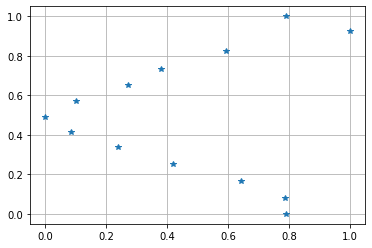

In [81]:
import matplotlib.pyplot as plt
plt.plot(x[15],y[15],linestyle='',marker='*')
plt.grid('TRUE')
#plt.xlim(xmin,xmax)
#plt.ylim(ymin,ymax)

In [87]:
x[0]

[0.9120298838130259,
 0.9000239267754437,
 0.8530375483182776,
 0.5897246564520376,
 0.39525592077157196,
 0.2545384555567279,
 0.03672297974033477,
 0.0,
 0.17286538039110108,
 0.41320668414052647,
 0.584577070657579,
 0.8497559604920741,
 0.8737120471348135,
 1.0]